# <ins>Protocole a transfert d'information minimal</ins>

****

_Contexte_: 

_Resume_: 

_Exemple_: 
****

### **Import la librairie qiskit et quelques librairies de math.**

In [1]:
# uncomment on first run to install qiskit library
##############################################
#!pip install qiskit
#!pip install qiskit-ibm-runtime
##############################################

#initialization
import matplotlib.pyplot as plt  # plotting the results
import numpy as np               # create and manage arrays
# import math                      # using more complexe math operations

# importing Qiskit
from qiskit import IBMQ, Aer, transpile, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy
from qiskit.transpiler import CouplingMap
import qiskit.quantum_info as qi

# import basic plot tools
from qiskit.visualization import plot_histogram, array_to_latex, plot_gate_map
from qiskit.circuit.library import MCMT, MCMTVChain, Diagonal

# import math tools
from math import floor, ceil, sqrt, pi, log2, cos, sin   # using more complexe math operations

### **Connexion a IBMQ et acces au processeur desire**

In [2]:
provider = IBMQ.load_account()

provider.backends()  # list of backends

backend = provider.get_backend("ibmq_belem")
cm = CouplingMap(backend.configuration().coupling_map) # get the coupling map of the processor
plot_gate_map(backend)  # plot the layout of the processor

print(backend.configuration().basis_gates)

/tmp/ipykernel_4535/3825718925.py:1: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  provider = IBMQ.load_account()


['id', 'rz', 'sx', 'x', 'cx', 'reset']


### Executer le code sur le backend
___

Le resultat recherche pour cet algorithme est la ou les positions des calendriers ou il y a une intersection.
Exemple: a = "0011" et b = "0110", le resultat est la position 2 (en commencant par 0). Le resultat affiche sera "10", le chiffre 2 en base 2.

In [12]:
def ReflectionGateMatrix(theta):
    isReflect_op = qi.Operator([[cos(theta), sin(theta)], 
                                [sin(theta), - cos(theta)]])
    return isReflect_op


def AddUvGate(qc, theta, q):
    Uv = ReflectionGateMatrix(theta)
    qc.unitary(Uv, q, label = 'U$_v$')

def AND(qc, r, x, y):

# Alice = qubit_0 , Bob = qubit_1

    theta = pi/(8 * r)
    iter = 4 * r - 1
    print("theta = ", theta)
    print("iter = ", iter)


    for i in range(iter - 1):
# - Alice: identity if x = 0, U if x = 1, then send to Bob
        if x == 1:
            #apply U
            AddUvGate(qc, theta, 0)
        
        #swap with Bob
        qc.swap(0, 1)
    
# - Bob: identity if y = 0, Z if y = 1, then send to Alice
        if y == 1:
            qc.z(1)
            
        #swap with Bob
        qc.swap(0, 1)    
        
# - Alice: identity if x = 0, U if x = 1, then send to Bob
    if x == 1:
        #apply U
        AddUvGate(qc, theta, 0)

    #swap with Bob
    qc.swap(0, 1)

# - Bob: identity if y = 0, Z if y = 1, then send to Alice
    if y == 1:
        qc.z(1)  
                 
        
# - Repeat Process 4r - 1 rounds, measure, if result = 1, answer = 1 if not 0
    qc.measure(1, 0)
    

theta =  0.19634954084936207
iter =  7


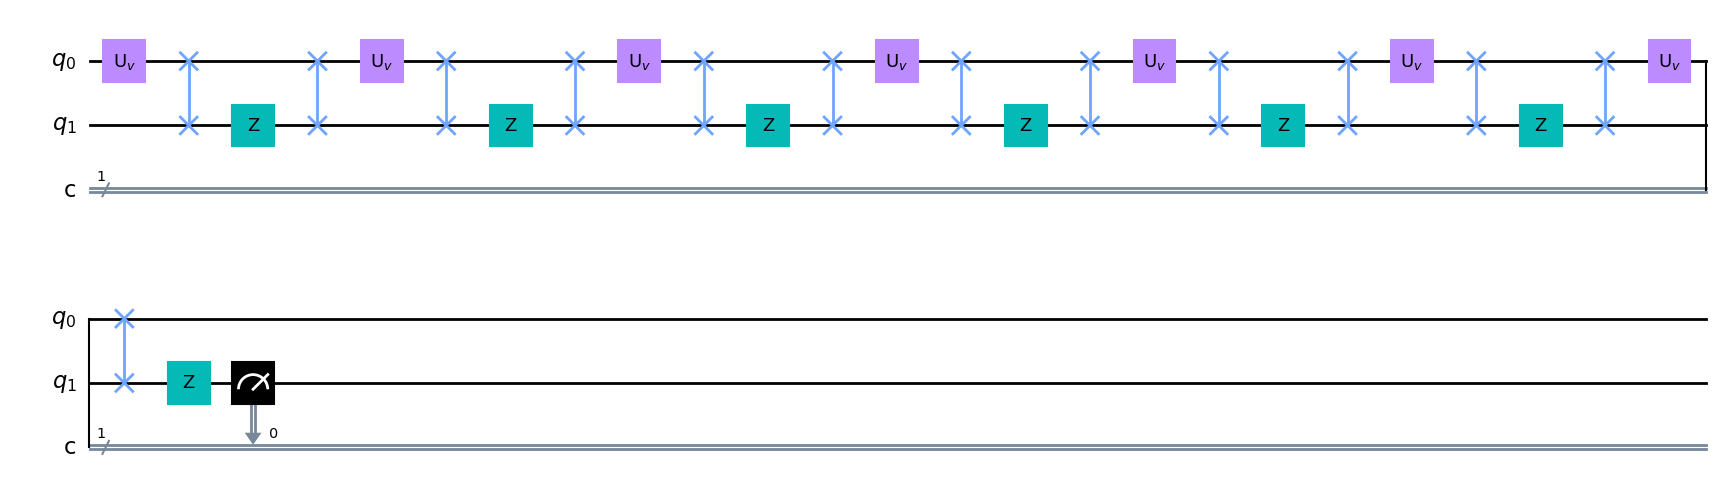

In [13]:
r = 2
qc = QuantumCircuit(2, 1)
q0 = qc.qubits[0]
q1 = qc.qubits[1]

AND(qc, r, 1, 1)
qc.draw('mpl')

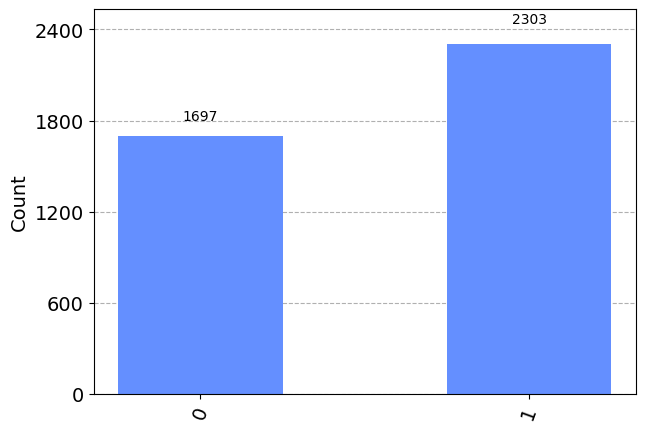

In [13]:
transpiled_qc = transpile(qc, backend)

job = backend.run(transpiled_qc)                  # run the job on the given backend
results = list(job.result().get_counts().items()) # list of all results
# threshold = int(1024/3)                           # arbitrary threshold to isolate good results
# InverseResults(results, threshold)                # inverse the position answers (qubits in qiskit are inversed)

plot_histogram(job.result().get_counts())         # uncomment to plot the result

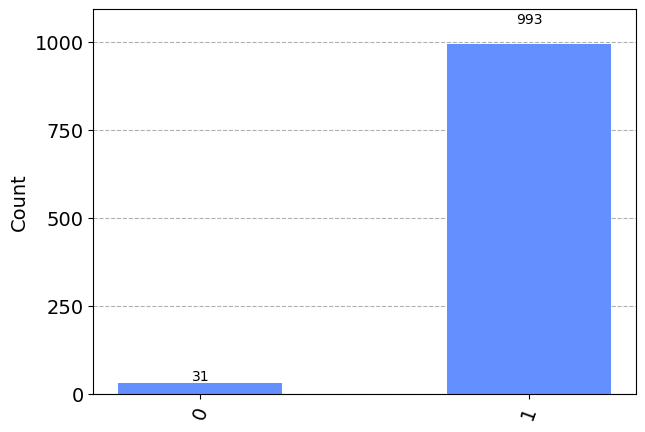

In [14]:
backend = Aer.get_backend('qasm_simulator') #  running on the simulator

transpiled_qc = transpile(qc, backend)

job = backend.run(transpiled_qc)                  # run the job on the given backend
results = list(job.result().get_counts().items()) # list of all results
# threshold = int(1024/3)                           # arbitrary threshold to isolate good results
# InverseResults(results, threshold)                # inverse the position answers (qubits in qiskit are inversed)

plot_histogram(job.result().get_counts())         # uncomment to plot the result

In [6]:
def RotationGateMatrix(theta):
    isReflect_op = qi.Operator([[cos(theta),- sin(theta)], 
                                [sin(theta), cos(theta)]])
    return isReflect_op

def AddRGate(qc, theta, q):
    R = RotationGateMatrix(theta)
    qc.unitary(R, q, label = 'R$_{\Theta}$')

def Alice(qc, theta, x):
    if x == 1:
        #apply U
        AddRGate(qc, theta, 0)
        
def Bob(qc, y):
    if y == 0:
        qc.reset(1)

def Charlie(qc, z):
    if z == 0:
        qc.reset(2)

def AND_reset(qc, r, x, y, z):
# Alice = qubit_0 , Bob = qubit_1, Charlie = qubit_2

    theta = pi/(8 * r)
    iter = 4 * r
    
    print("theta = ", theta)
    print("iter = ", iter)

    for i in range(iter - 1):
        Alice(qc, theta, x)

        #swap with Bob
        qc.swap(0, 1)
    
        Bob(qc, y)
            
        #swap with Charlie
        qc.swap(1, 2)    

        Charlie(qc, z)
        
        #swap with Alice
        qc.swap(2, 0)   
        
    Alice(qc, theta, x)

    #swap with Bob
    qc.swap(0, 1)

    Bob(qc, y)

    #swap with Charlie
    qc.swap(1, 2)    

    Charlie(qc, z)   
                 
        
# - Repeat Process 4r - 1 rounds, measure, if result = 1, answer = 1 if not 0
    qc.measure(2, 0)  

In [7]:
r = 1
qc = QuantumCircuit(3, 1)

AND_reset(qc, r, 1, 1, 1)
# qc.draw('mpl')

theta =  0.39269908169872414
iter =  4


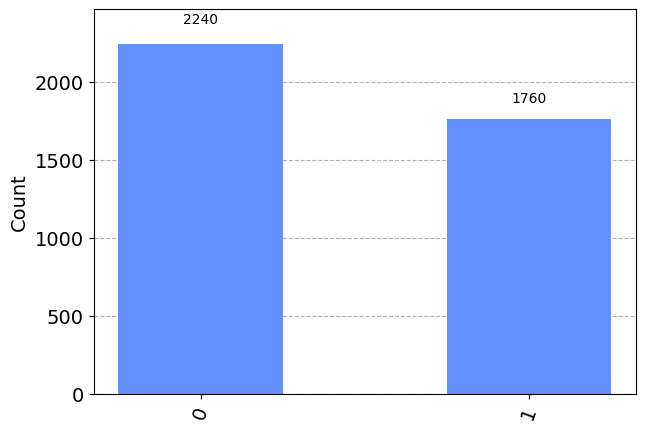

In [60]:
transpiled_qc = transpile(qc, backend)

job = backend.run(transpiled_qc)                  # run the job on the given backend
results = list(job.result().get_counts().items()) # list of all results
# threshold = int(1024/3)                           # arbitrary threshold to isolate good results
# InverseResults(results, threshold)                # inverse the position answers (qubits in qiskit are inversed)

plot_histogram(job.result().get_counts())         # uncomment to plot the result

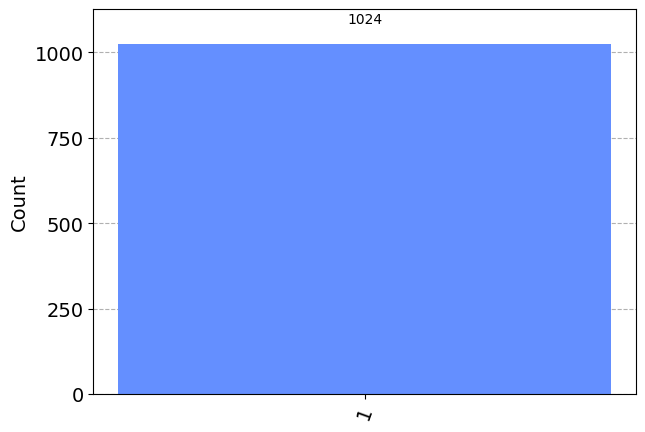

In [8]:
backend = Aer.get_backend('qasm_simulator') # uncomment if you want to run on a simulator

transpiled_qc = transpile(qc, backend)

job = backend.run(transpiled_qc)                  # run the job on the given backend
results = list(job.result().get_counts().items()) # list of all results
# threshold = int(1024/3)                           # arbitrary threshold to isolate good results
# InverseResults(results, threshold)                # inverse the position answers (qubits in qiskit are inversed)

plot_histogram(job.result().get_counts())         # uncomment to plot the result